# CaCO$_3$ Cluster Analysis

This interactive notebook uses MDAnalysis and NetworkX libraries to determine ion species emerging in supersaturated CaCO$_3$(aq) solution siumulations. Liquid-liquid phase separation occurs in these solutions, establishing a pseudo-equilibrium between dense liquid CaCO$_3$ phases and lean ion solutions, [see Smeets, Finney et al.](https://www.pnas.org/doi/10.1073/pnas.1700342114) However, due to finite size effects, discussed by e.g., [Li et al.](https://www.biorxiv.org/content/10.1101/2022.11.11.515961v1), phase seapartion is limited to simulations with sufficient numbers of ions to supply and sustain the growth of the emerging phase beyond some critical size threshold.

In what follows, we use the functionaliity of MDAnalysis and NetworkX to build adjacency matrices on which we perform graph analyses to establish connected subsets of ions as a function of simulation time. Ions are connected through their first coordination spheres, informed by considering cation-anion pair distribution functions. Based on the cluster analyses, we establish the properties of lean ion solutions and dense liquid phases and the dynamics for phase separation.

### Import the necessary libraries

In [1]:
# MDAnalysis
import MDAnalysis as mda
import nglview as nv

# NetworkX
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout as layout

# Data structures
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline
import seaborn as sns

# Statistical analyses
import scipy.spatial.distance as ssd
from scipy import constants
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.neighbors import KernelDensity

# Misc.
import time
import random

In [2]:
print('MDAnalysis v.',mda.__version__)
print('NGLView v.',nv.__version__)
print('NetworkX v.',nx.__version__)

MDAnalysis v. 2.1.0
NGLView v. 3.0.3
NetworkX v. 2.4


### Set pyplot paramters for publication-ready figures

In [3]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": ["computer modern roman"],
    "font.size": 14})
plw = 0.6
pcs = 3
pms = 3
bfillc = [0.9,0.9,0.9]
plt.rcParams['axes.linewidth'] = plw
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = plw
plt.rcParams['xtick.minor.width'] = plw
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.major.size'] = 4.5
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.major.width'] = plw
plt.rcParams['ytick.minor.width'] = plw
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.major.size'] = 5
plt.rcParams["figure.figsize"] = (5,4)

### Load the LAMMPS xtc trajectory files

In [4]:
# 1. First load a LAMMPS data file
LAMMPSDATA = 'lmp.data'
u = mda.Universe(LAMMPSDATA, atom_style="id resid type charge x y z")
# Now load trajectory data
traj_list = ['trajectory.17.xtc']
%time u.load_new(traj_list)

print('Universe:',u.trajectory)

CPU times: user 5.02 ms, sys: 0 ns, total: 5.02 ms
Wall time: 5.02 ms
Universe: <XTCReader trajectory.17.xtc with 14735 frames of 30500 atoms>


/home/aaron/Packages/anaconda3/lib/python3.7/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: 1
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/aaron/Packages/anaconda3/lib/python3.7/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: 2
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/aaron/Packages/anaconda3/lib/python3.7/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: 3
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/aaron/Packages/anaconda3/lib/python3.7/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: 4
  warnings.warn("Failed to guess the mass for the f

### Select the atoms of interest

In [5]:
calcium = u.select_atoms('type 1')
carbon = u.select_atoms('type 2')
ionclusters = u.select_atoms('type 1 2')
carbonate = u.select_atoms('type 2 4')
wateroxygen = u.select_atoms('type 5')
water = u.select_atoms('type 3 5')

### Set the atom charges and masses

In [6]:
# Atomic masses
mca = 40.078
mc = 12.0107
mo = 15.9994
mh = 1.0079

calcium.masses = mca
carbon.masses = mc
carbonate.masses = mc + 3*mo
wateroxygen.masses = mo
water.masses = mo + 2*mh

# Gale force field charges
qca = 2.0000
qc4 = 1.123285
qo4 = -1.041095
qo2 = -0.820000
qh2 = 0.410000

calcium.charges = qca
carbon.charges = qc4
carbonate.charges = qc4 + 3*qo4
wateroxygen.charges = qo2
water.charges = qo2 + 2*qh2

### Calculate the Ca-C radial distribution function

The radial distribution function is determined according to,
<br>
<br>
<center> $g_{ab}(r) = (N_{a} N_{b})^{-1} \sum_{i=1}^{N_a} \sum_{j=1}^{N_b} \langle \delta(|\mathbf{r}_i - \mathbf{r}_j| - r) \rangle$

    
where $N$ and $\mathbf{r}$ are particle numbers and Cartesian coordinate vectors, respectively. See the [documentation](https://docs.mdanalysis.org/1.1.1/documentation_pages/analysis/rdf.html) for further information.

In [7]:
# Use the functionality provided by MDAnalysis
from MDAnalysis.analysis import rdf

irdf = rdf.InterRDF(calcium, carbon,
                    nbins=150,  # default
                    range=(0.0, 10.0),  # distance in angstroms
                   )
%time irdf.run()

CPU times: user 28.2 s, sys: 164 ms, total: 28.4 s
Wall time: 28.3 s


### Use the potential of mean force for ion pairing to establish the first Ca sphere radius

The potential of mean force ($\phi(r)$) for Ca-C ion association can be determined from $g_{Ca-C}(r)$ according to,
<br>
<br>
<center> $\Delta \phi(r) = -k_{\mathrm{B}}T \ln{g_{Ca-C}(r)}$

It is important to recognise that without enhanced sampling of high energy states, the relative energies between states might not be converged and that the barriers for transition are likely to be inaccurate. For further information see [Finney and Salvalaglio](https://pubs.rsc.org/en/content/articlelanding/2022/fd/d1fd00089f).

/home/aaron/Packages/anaconda3/lib/python3.7/site-packages/MDAnalysis/analysis/rdf.py:425: DeprecationWarning: The `rdf` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rdf` instead
  warnings.warn(wmsg, DeprecationWarning)
/home/aaron/Packages/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/home/aaron/Packages/anaconda3/lib/python3.7/site-packages/MDAnalysis/analysis/rdf.py:417: DeprecationWarning: The `bins` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.bins` instead
  warnings.warn(wmsg, DeprecationWarning)
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


First PMF minimimum -11.236312543487935 r= [[3.43333333]] Angstroms
First sphere truncation distance in Angstroms [[4.03333333]]


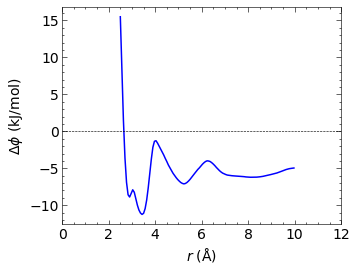

In [8]:

# Define thermal energy
kT = constants.R*298/1000

# Boltzmann invert and plot
pmf = -kT*np.log(irdf.rdf)
plt.figure()
plt.plot(irdf.bins, pmf,'b')
plt.plot([0 ,12],[0,0],'k--',linewidth=plw)
plt.xlim(0,12)
plt.xlabel(r'$r \; (\mathrm{\AA})$')
plt.ylabel(r'$\Delta \phi$ (kJ/mol)')

# Check the truncation distance for inner sphere contacts based on the pmf
delta = irdf.bins[1] - irdf.bins[0]
bcutoff = int(5.0/delta) # Set the maximum distance for the truncation

# Identify and report the first minimum
pmfmin = np.argwhere(pmf == np.amin(pmf[1:bcutoff]))
print("First PMF minimimum",np.amin(pmf[1:bcutoff]),"r=",irdf.bins[pmfmin],"Angstroms")

# Identify and report the first maximum
pmfmax = np.amax(pmf[np.int(pmfmin):bcutoff*2])
truncation = np.argwhere(pmf == pmfmax)
print("First sphere truncation distance in Angstroms",irdf.bins[truncation])


## Loop through frames and identify the droplet as the largest ion cluster

Now we analyse the trajecories. We use the ```contact_matrix``` functionality from MDAnalysis to build the adjacency matrix and take this as input to NetworkX to construct the graph.

In [9]:
from MDAnalysis.analysis.distances import contact_matrix
import MDAnalysis.transformations as trans

# Set the cutoff for first sphere coordination
trunc_distance = irdf.bins[truncation] 

# Scaling factors
molarity_scaling = 1e+27/constants.Avogadro
molal_scaling = 1/((len(wateroxygen)*water.masses[0]/1000))

# Plotting arrays
time = [] # simulation time
ncls = [] # number of clusters
clsz = [] # cluster sizes
dsiz = [] # droplet size
dchg = [] # droplet charge
drgy = [] # droplet radius of gyration
ccat = [] # cation concentration
cani = [] # cation concentration
cdim = [] # dimer concentration
ctet = [] # tetramer concentration
chex = [] # hexamer concentration
bcat = [] # cation molality
bani = [] # cation molality

frames = 0
# Loop through the frames
for ts in u.trajectory[0:-1:100]:
    
    # Generate the adjacancy matrix
    adjmatrix = contact_matrix(ionclusters.positions, cutoff=trunc_distance, returntype='numpy', box=ts.dimensions)

    # Generate a graph from the adjacency matrix
    Graph = nx.Graph(adjmatrix)
    
    # Size of connected components in the graph
    cluster_size = [len(c) for c in sorted(nx.connected_components(Graph), key=len, reverse=True)]
    largest_cluster_size = cluster_size[0]

    # Number of connected components
    number_of_clusters = len(cluster_size)    
    
    # List of nodes in every connected component
    cluster_members = [c for c in sorted(nx.connected_components(Graph), key=len, reverse=True)]
    

    # Get the components of the largest cluster
    largest_cluster_indices = list(cluster_members[0])
    droplet = u.atoms[(ionclusters.indices[largest_cluster_indices])]
                      
    # PROPERTIES OF THE DROPLET
    droplet_charge = droplet.total_charge()
    droplet_center = droplet.center_of_mass(wrap=True)
    droplet_rgyr = droplet.radius_of_gyration(wrap=True)
    
    # PROPERTIES OF THE SOLUTION
    monomer_charges = [] 
    monomer_indices = np.argwhere(np.array(cluster_size) == 1)
    
    # Get the dispersed ions
    for i in range(0,monomer_indices.size):      
        at = list(cluster_members[np.int(monomer_indices[i])]) # ion index

        monomer_charges.append(u.atoms[at].charges)
        
    # Count the number of positive and negative ions
    number_cations = np.sum(np.array(monomer_charges) > 0)
    number_anions = np.sum(np.array(monomer_charges) < 0)
    concn_cations = number_cations/ts.dimensions[0]**3*molarity_scaling*1000 #mM
    concn_anions = number_anions/ts.dimensions[0]**3*molarity_scaling*1000 #mM
    molal_cations = number_cations*molal_scaling*1000 #mmol
    molal_anions = number_anions*molal_scaling*1000 #mmol
    
    dims = np.sum(np.array(cluster_size) == 2)
    tets = np.sum(np.array(cluster_size) == 4)
    hexs = np.sum(np.array(cluster_size) == 6)
    cdim.append(dims/ts.dimensions[0]**3*molarity_scaling)
    ctet.append(tets/ts.dimensions[0]**3*molarity_scaling)
    chex.append(hexs/ts.dimensions[0]**3*molarity_scaling)   

    # Record the data for plotting
    time.append(ts.time/1000) # use ns units
    ncls.append(number_of_clusters)
    clsz.extend(cluster_size[:])
    dsiz.append(largest_cluster_size)
    dchg.append(droplet_charge)
    drgy.append(droplet_rgyr/10)
    ccat.append(concn_cations)
    cani.append(concn_anions)
    bcat.append(molal_cations)
    bani.append(molal_anions)
    
    
    frames += 1

## Determine the size weighted cluster size distribution

The distribution indicates the probability of finding an ion within a cluster of size $N$.

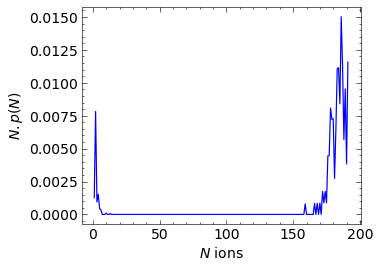

In [10]:
# Generate the probability of cluster sizes from the cluster size array clsz
clsz = np.array(clsz)
histmin = np.amin(clsz)
histmax = np.amax(clsz)
xaxis = np.arange(1,histmax+1)
bins = xaxis.size

plt.figure()
hist, bin_edges = np.histogram(clsz, density=True, bins=bins)
plt.ylabel("$N.p(N)$")
plt.xlabel("$N$ ions")
plt.plot(xaxis,(hist/frames)*xaxis,'b-',linewidth=2*plw)

## Lean solution ion species

We now estimate the free energies for the formation of ion clusters in lean solution frm $p(N)$. These were ascribed to _thermodynamically stable_ prenucleation clusters.

We consider the estimates of $\Delta F$ using Gaussian kernel densities constructed using two separate approaches, with functionality from SciPy and scikit-learn.

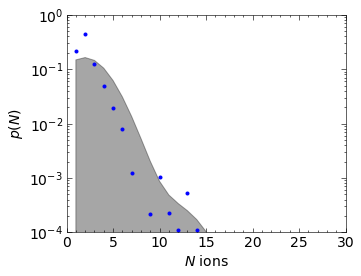

In [11]:
from scipy import stats
from sklearn.neighbors import KernelDensity


# Set an upper limit for N
nlim=30

# Estimate the Gaussian kernel density using SciPy:
kernel = stats.gaussian_kde(clsz,bw_method=0.01)
# Plot
plt.plot(xaxis[:nlim],kernel(xaxis)[:nlim],'bo',markersize=pms)



# Estimate the Gaussian kernel density using scikit-learn:
kde = KernelDensity(bandwidth=2, kernel='gaussian')
kde.fit(clsz[:, None])
# score_samples returns the log of the probability density
logprob = kde.score_samples(xaxis[:, None])
# Plot
plt.fill_between(xaxis[:nlim], np.exp(logprob)[:nlim], color='black',alpha=0.35)


plt.ylabel("$p(N)$")
plt.xlabel("$N$ ions")
plt.yscale("log")
plt.xlim(0,nlim)
plt.ylim(0.0001,1)
plt.savefig('pN.png',dpi=300)

We can evaluate $\Delta F \approx -k_\mathrm{B}T \ln{p(N)}$

/home/aaron/Packages/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


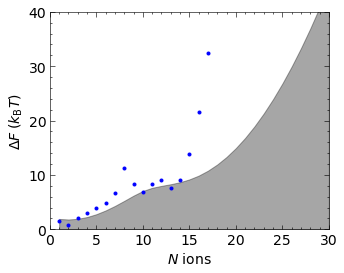

In [12]:
fe1 = -np.log(kernel(xaxis))
fe2 = -np.log(np.exp(logprob))

plt.plot(xaxis[:nlim],fe1[:nlim],'bo',markersize=pms)
plt.fill_between(xaxis[:nlim], fe2[:nlim], color='black',alpha=0.35)

plt.xlim(0,nlim)
plt.ylim(0,40)
plt.ylabel("$\Delta F \;(k_\mathrm{B}T)$")
plt.xlabel("$N$ ions")
plt.savefig('FE.png',dpi=300)

### Report average ion molalities in the steay state

In [13]:
print('Mean anion molality and molarity (with uncertainties)')
print(np.mean(bani),np.std(bani),np.mean(bani)/(molal_scaling*1000),np.std(bani)/(molal_scaling*1000))

Mean anion molality and molarity (with uncertainties)
6.375997205963011 4.801336830821919 1.1486486486486485 0.8649704327462303


In [14]:
print('Mean cation molality and molarity (with uncertainties)')
print(np.mean(bcat),np.std(bcat),np.mean(bcat)/(molal_scaling*1000),np.std(bani)/(molal_scaling*1000))

Mean cation molality and molarity (with uncertainties)
3.112986871146647 3.0421396034180233 0.5608108108108107 0.8649704327462303


## Dense CaCO$_3$ liquid 

Text(0.5, 0, 'time (ns)')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


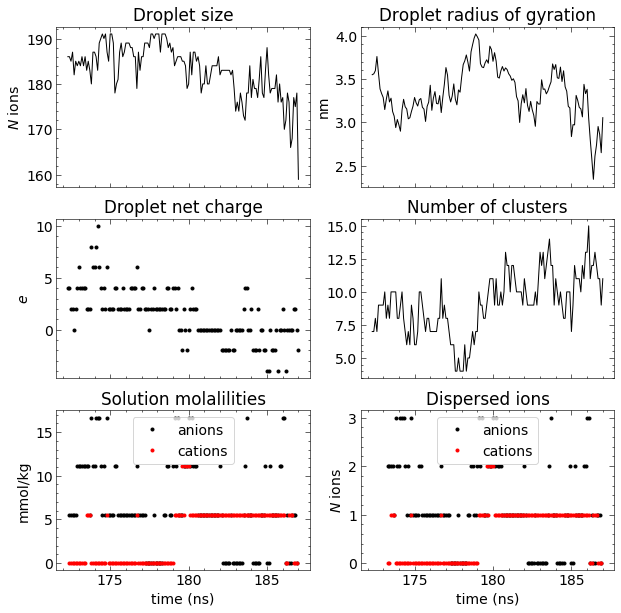

In [15]:
#Plot the time series of droplet properties

fig, [[ax0, ax1], [ax2, ax3], [ax4, ax5]] = plt.subplots(nrows=3, ncols=2, sharex=True,figsize=(10,10))  

# Droplet size
ax0.title.set_text('Droplet size')
ax0.set_ylabel("$N$ ions")
ax0.plot(time,dsiz,'k-',linewidth=1)

# Radius of gyration
ax1.title.set_text('Droplet radius of gyration')
ax1.set_ylabel("nm")
ax1.plot(time,drgy,'k-',linewidth=1)

# Droplet net ionic charge
ax2.title.set_text('Droplet net charge')
ax2.set_ylabel("$e$")
ax2.plot(time,dchg,'ko',markersize=pms)

# Number of clusters
ax3.title.set_text('Number of clusters')
ax3.set_ylabel("")
ax3.plot(time,ncls,'k-',linewidth=1)

# Free ion molalities
ax4.title.set_text('Solution molalilities')
ax4.set_ylabel("mmol/kg")
ax4.plot(time[1:-1],bani[1:-1],'ko',markersize=pms, label='anions')
ax4.plot(time[1:-1],bcat[1:-1],'ro',markersize=pms, label='cations')
legend = ax4.legend(loc='upper center')
ax4.set_xlabel("time (ns)")

# Free ion molalities
ax5.title.set_text('Dispersed ions')
ax5.set_ylabel("$N$ ions")
ax5.plot(time[10:-1],np.array(bani[10:-1])/(molal_scaling*1000),'ko',markersize=pms, label='anions')
ax5.plot(time[10:-1],np.array(bcat[10:-1])/(molal_scaling*1000),'ro',markersize=pms, label='cations')
legend = ax5.legend(loc='upper center')
ax5.set_xlabel("time (ns)")


### Visualise the largest cluster using NGLView

In [16]:
view = nv.show_mdanalysis(droplet)
view.clear_representations()
view.add_surface(selection="droplet", opacity=0.3)
view.background = 'black'
view.center()
view


NGLWidget(background='black', max_frame=14734)